In [172]:
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

## Data Loading 

In [113]:
df = pd.read_excel("Online Retail.xlsx")
print("Number of rows in the dataset: ", df.shape[0])
print("Number of columns in the dataset: ", df.shape[1])

Number of rows in the dataset:  541909
Number of columns in the dataset:  8


In [114]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Inspection & Data Cleaning

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [117]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [118]:
cancelled = df[df['InvoiceNo'].astype(str).str.startswith('C')]
negative_price = df[df['UnitPrice'] < 0]
negative_quantity = df[df['Quantity'] < 0]
print("Number of cancelled orders: ", cancelled.shape[0])
print("Number of orders with price corrections: ", negative_price.shape[0])
print("Number of rows with negative 'Quantity': ", negative_quantity.shape[0])

Number of cancelled orders:  9288
Number of orders with price corrections:  2
Number of rows with negative 'Quantity':  10624


The dataset contains negative values for both Quantity and UnitPrice. Negative values for Quantity likely represent canceled orders, which we can identify by checking if InvoiceNo starts with the letter 'C'. These transactions are separated into a new dataframe for deeper insights, such as analyzing patterns in cancellations, frequent reasons, or products that are often returned.

Negative values for UnitPrice might indicate corrections or anomalies in pricing, which could distort the analysis. These entries have been removed to ensure the integrity and accuracy of our findings, as retaining them could bias metrics like average sales or trends.

In [120]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

Lastly, we check for the number of duplicated orders and remove any missing values. 

In [122]:
print("Number of duplicated orders:", len(df[df.duplicated()]))

Number of duplicated orders: 5226


In [123]:
df.drop_duplicates(inplace = True)
df = df.dropna()

In [124]:
print("Number of rows in the dataset: ", df.shape[0])

Number of rows in the dataset:  392692


In [125]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Feature Engineering

In [127]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#### Calculating Total Sales

In [129]:
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

#### Adding Hour, Day, Month, and Year Features 

In [131]:
df['Hour'] = df['InvoiceDate'].dt.hour
df['Day'] = df['InvoiceDate'].dt.day_name()
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceYear']  = df['InvoiceDate'].dt.year
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Hour,Day,InvoiceMonth,InvoiceYear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,8,Wednesday,12,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,Wednesday,12,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,8,Wednesday,12,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,Wednesday,12,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,Wednesday,12,2010


## Data Analysis

#### Monthly Sales Trend

In [166]:
monthly_sales = df.groupby('InvoiceMonth')['TotalSales'].sum().reset_index()
monthly_sales['MonthName'] = monthly_sales['InvoiceMonth'].apply(lambda x: calendar.month_name[x])
monthly_sales

,InvoiceMonth,TotalSales,MonthName
0,1,568101.310,January
1,2,446084.920,February
2,3,594081.760,March
3,4,468374.331,April
4,5,677355.150,May
5,6,660046.050,June
6,7,598962.901,July
7,8,644051.040,August
8,9,950690.202,September
9,10,1035642.450,October


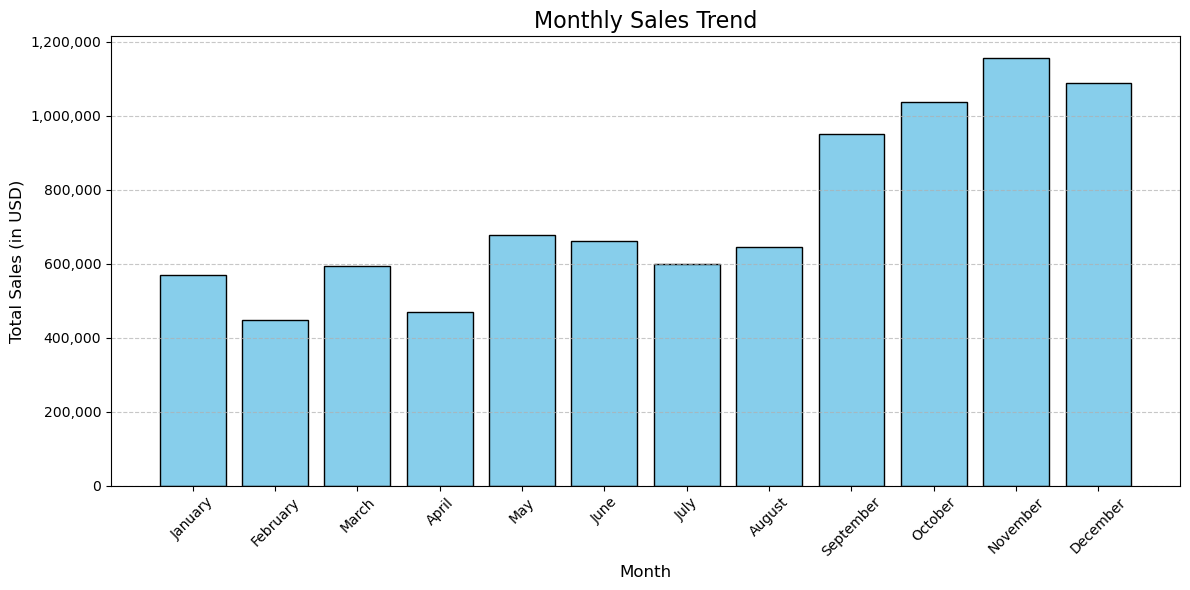

In [174]:
def format_y_axis(value, tick_number):
    return f'{int(value):,}'

plt.figure(figsize=(12, 6))
plt.bar(monthly_sales['MonthName'], monthly_sales['TotalSales'], color='skyblue', edgecolor='black')
plt.title('Monthly Sales Trend', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales (in USD)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_axis))  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Top 10 Products for 2010 with Most Purchased Month

In [192]:
top_2010_products = df[df['InvoiceYear'] == 2010]
top_products_2010 = (
    top_2010_products.groupby('Description')['Quantity'].sum()
    .nlargest(10)
    .reset_index()
)

# Find the month with the most purchases for each product in 2010
top_2010_months = []
for product in top_products_2010['Description']:
    product_data = top_2010_products[top_2010_products['Description'] == product]
    top_month = (
        product_data.groupby('InvoiceMonth')['Quantity'].sum()
        .idxmax()
    )
    top_2010_months.append(calendar.month_name[top_month])

top_products_2010['MostPurchasedMonth'] = top_2010_months

top_products_2010

,Description,Quantity,MostPurchasedMonth
0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5139,December
1,WHITE HANGING HEART T-LIGHT HOLDER,3611,December
2,PACK OF 72 RETROSPOT CAKE CASES,3572,December
3,HAND WARMER BABUSHKA DESIGN,3341,December
4,MINI PAINT SET VINTAGE,2700,December
5,PACK OF 12 LONDON TISSUES,2656,December
6,GROW A FLYTRAP OR SUNFLOWER IN TIN,2616,December
7,ASSORTED COLOUR BIRD ORNAMENT,2259,December
8,CREAM HEART CARD HOLDER,2253,December
9,RED HARMONICA IN BOX,2157,December


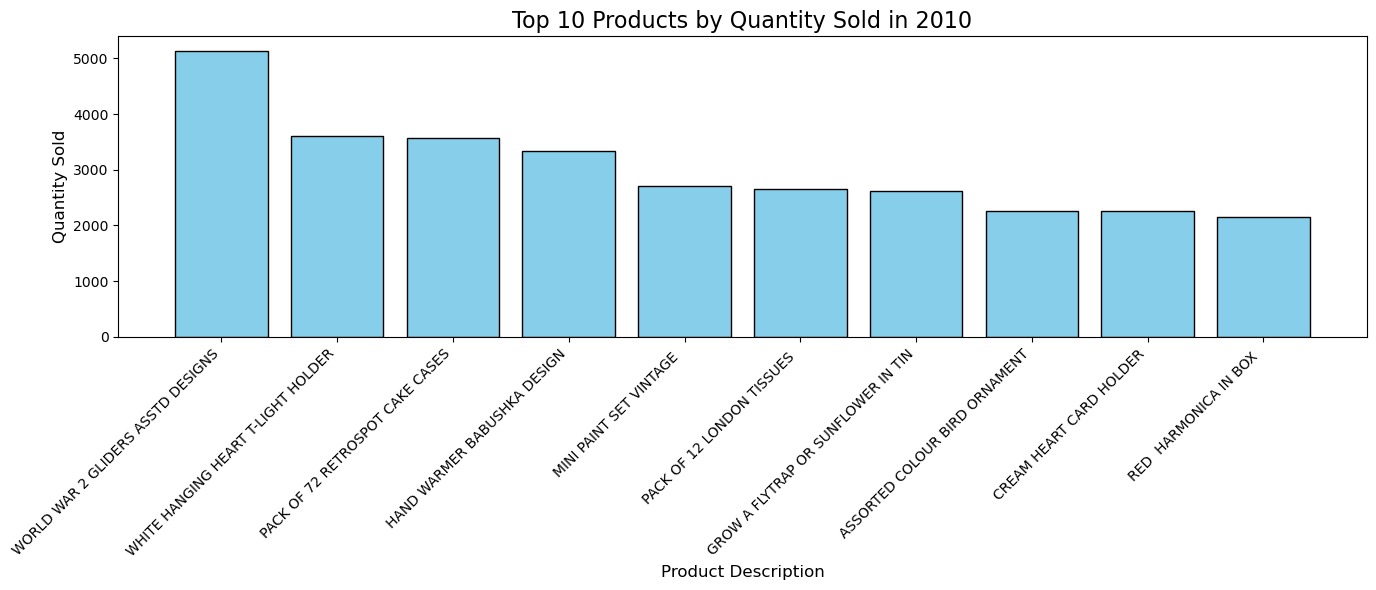

In [180]:
plt.figure(figsize=(14, 6))
plt.bar(top_products_2010['Description'], top_products_2010['Quantity'], color='skyblue', edgecolor='black')
plt.title('Top 10 Products by Quantity Sold in 2010', fontsize=16)
plt.xlabel('Product Description', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

#### Top 10 Products for 2011 with Most Purchased Month

In [ ]:
top_2011_products = df[df['InvoiceYear'] == 2011]
top_products_2011 = (
    top_2011_products.groupby('Description')['Quantity'].sum()
    .nlargest(10)
    .reset_index()
)

top_2011_months = []
for product in top_products_2011['Description']:
    product_data = top_2011_products[top_2011_products['Description'] == product]
    top_month = (
        product_data.groupby('InvoiceMonth')['Quantity'].sum()
        .idxmax()
    )
    top_2011_months.append(calendar.month_name[top_month])

top_products_2011['MostPurchasedMonth'] = top_2011_months

top_products_2011

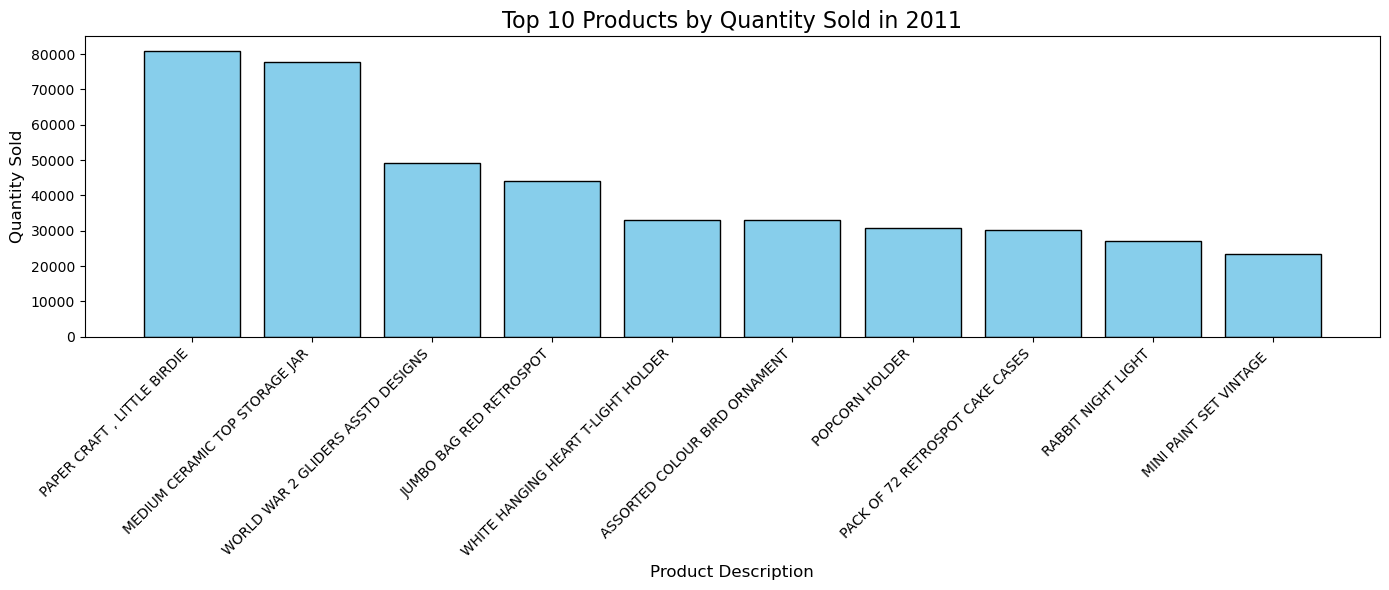

In [184]:
plt.figure(figsize=(14, 6))
plt.bar(top_products_2011['Description'], top_products_2011['Quantity'], color='skyblue', edgecolor='black')
plt.title('Top 10 Products by Quantity Sold in 2011', fontsize=16)
plt.xlabel('Product Description', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()